# Recommender System using Embeddings

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

#### There are null values in CustomerID and Description columns 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df = df.dropna(how="any")

In [7]:
df['StockCode']= df['StockCode'].astype(str)
df['CustomerID']= df['CustomerID'].astype(int).astype(str)

In [8]:
n_customers = df.CustomerID.nunique()

#### Saving part of customers for test

In [24]:
customers_train = random.Random(500).sample(np.unique(df.CustomerID).tolist(), k=int(n_customers*0.95))
train = df[df.CustomerID.isin(customers_train)]
test = df[~df.CustomerID.isin(customers_train)]
customers_test = np.unique(test.CustomerID).tolist()

#### Get products which are bought by a specific customer

In [25]:
purchases_train = []
for customer in tqdm(customers_train):
    temp = train[train.CustomerID == customer]
    purchases_train.append(temp.StockCode.tolist())

100%|██████████████████████████████████████████████████████████████████████████████| 4153/4153 [01:47<00:00, 38.78it/s]


In [27]:
purchases_test = []
for customer in tqdm(customers_test):
    temp = test[test.CustomerID == customer]
    purchases_test.append(temp.StockCode.tolist())

100%|███████████████████████████████████████████████████████████████████████████████| 219/219 [00:00<00:00, 495.68it/s]


#### Train Word2Vec Model

In [28]:
#Skip-gram and negative sampling used, learning rate decaying from alpha to min_alpha
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, 
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3835439, 3874340)

In [29]:
#To save memory
model.init_sims(replace=True)

In [30]:
print(model)

Word2Vec(vocab=3188, size=100, alpha=0.03)


In [31]:
X = model[model.wv.vocab]

#### Visualize Embeddings

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")
X_embedded = tsne.fit_transform(X)

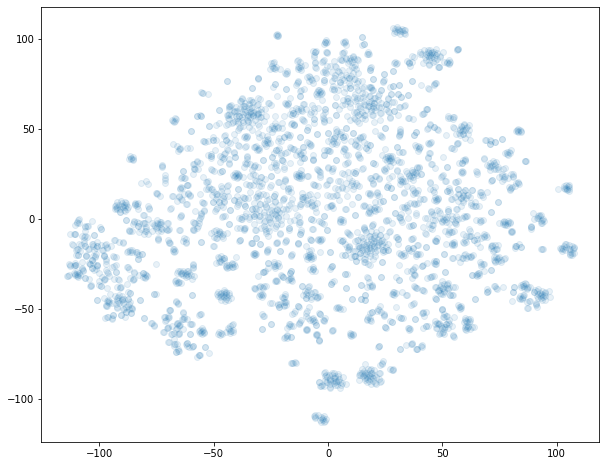

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=.1)

#### There are Stock codes with multiple descriptions

In [37]:
train[["StockCode", "Description"]].groupby("StockCode").nunique().sort_values("Description")

,StockCode,Description
StockCode,,
10002,1,1
35916A,1,1
35916B,1,1
35916C,1,1
35920,1,1
...,...,...
23231,1,3
23396,1,3
23209,1,3


In [43]:
prod_desc = train[["StockCode", "Description"]]

prod_desc.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = prod_desc.groupby('StockCode')['Description'].apply(list).to_dict()
products_dict

{'10002': ['INFLATABLE POLITICAL GLOBE '],
 '10080': ['GROOVY CACTUS INFLATABLE'],
 '10120': ['DOGGY RUBBER'],
 '10123C': ['HEARTS WRAPPING TAPE '],
 '10124A': ['SPOTS ON RED BOOKCOVER TAPE'],
 '10124G': ['ARMY CAMO BOOKCOVER TAPE'],
 '10125': ['MINI FUNKY DESIGN TAPES'],
 '10133': ['COLOURING PENCILS BROWN TUBE'],
 '10135': ['COLOURING PENCILS BROWN TUBE'],
 '11001': ['ASSTD DESIGN RACING CAR PEN'],
 '15030': ['FAN BLACK FRAME '],
 '15034': ['PAPER POCKET TRAVELING FAN '],
 '15036': ['ASSORTED COLOURS SILK FAN'],
 '15039': ['SANDALWOOD FAN'],
 '15044A': ['PINK PAPER PARASOL '],
 '15044B': ['BLUE PAPER PARASOL '],
 '15044C': ['PURPLE PAPER PARASOL'],
 '15044D': ['RED PAPER PARASOL'],
 '15056BL': ['EDWARDIAN PARASOL BLACK'],
 '15056N': ['EDWARDIAN PARASOL NATURAL'],
 '15056P': ['EDWARDIAN PARASOL PINK'],
 '15058A': ['BLUE POLKADOT GARDEN PARASOL'],
 '15058B': ['PINK POLKADOT GARDEN PARASOL'],
 '15058C': ['ICE CREAM DESIGN GARDEN PARASOL'],
 '15060B': ['FAIRY CAKE DESIGN UMBRELLA'],
 '16

#### Try recommendation

In [44]:
def find_similar(v, n):
    similar = model.similar_by_vector(v, topn= n+1)[1:]
    sim_products = []
    for product in similar:
        pair = (products_dict[product[0]][0], product[1])
        sim_products.append(pair)     
    return sim_products  

In [50]:
products_dict['21786']

['POLKADOT RAIN HAT ']

In [49]:
find_similar(model['21786'], n=10)

[('RAIN PONCHO RETROSPOT', 0.7566730976104736),
 ('THE KING GIFT BAG 25x24x12cm', 0.5554126501083374),
 ('RAIN PONCHO ', 0.532250165939331),
 ('COSY SLIPPER SHOES SMALL GREEN', 0.5114819407463074),
 ('36 PENCILS TUBE POSY', 0.48179030418395996),
 ('KIDS RAIN MAC BLUE', 0.47530704736709595),
 ('COSY SLIPPER SHOES SMALL  RED ', 0.47206687927246094),
 ('TRAVEL SEWING KIT', 0.4700389504432678),
 ('ENVELOPE 50 CURIOUS IMAGES', 0.44643381237983704),
 ('FOLDING UMBRELLA BLACKBLUE POLKADOT', 0.4423547089099884)]